<a href="https://www.kaggle.com/code/parisrohan/rp-titanic-1?scriptVersionId=91031170" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load data and required libraries

In [2]:
#Load required libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Load train data
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Load test data
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
#Get the dataset shape
df_train.shape, df_test.shape

((891, 12), (418, 11))

Observation: Train dataset has 891 rows and 12 columns; Test data has 418 rows and 11 columns

## EDA on train dataset

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#Functon to get count of missing values in each column
def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [8]:
#Missing values in train data
print(get_cols_with_missing_values(df_train))

Age         177
Cabin       687
Embarked      2
dtype: int64


Observation: The target feature 'Survived' has no missing values in train dataset

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:xlabel='Survived', ylabel='count'>

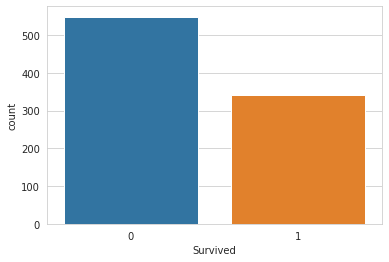

In [10]:
#0 - not survived , 1 - survived
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=df_train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

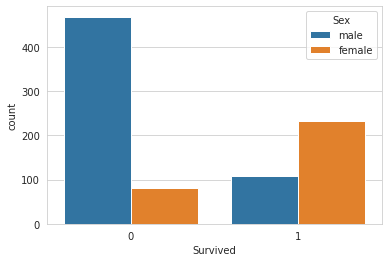

In [11]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=df_train, hue='Sex')

Observation: From the above two plots we can observe that
* Total number of people who did not survive > Total number of people who survived
* In the people who did not survive, Male passengers > Female passengers
* In the people who survived,        Male passengers < Female passengers

<AxesSubplot:xlabel='Survived', ylabel='count'>

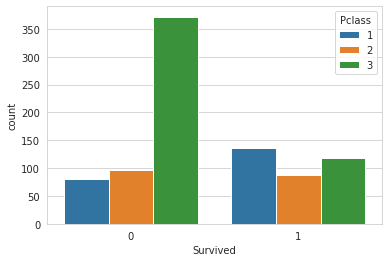

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=df_train, hue='Pclass')

Observation: The majority of passengers who did not survive, belonged to the lower economic class (i.e Pclass=3)

In [13]:
#Get categorical and numerical columns in train data
categorical_cols=[cname for cname in df_train.columns if df_train[cname].dtypes=='object']
numerical_cols=[cname for cname in df_train.columns if df_train[cname].dtypes!='object']

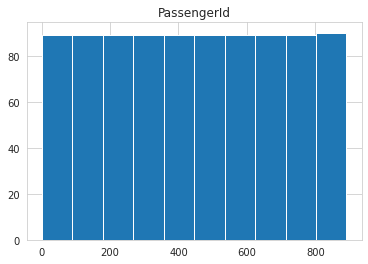

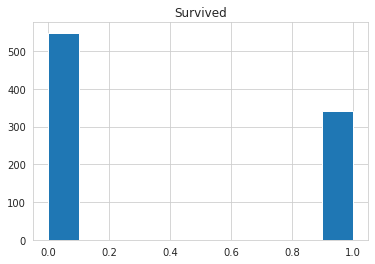

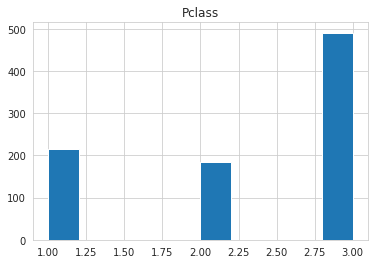

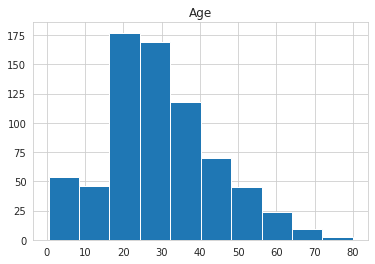

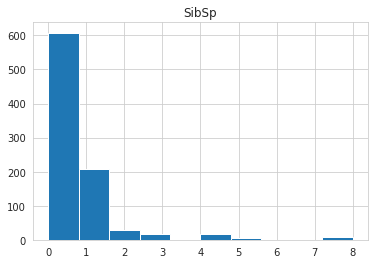

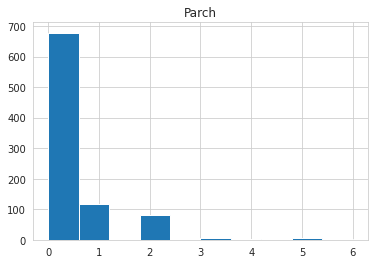

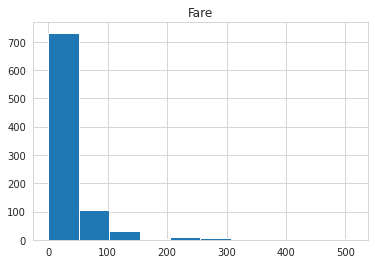

In [14]:
#Distribution of numerical data
for i in numerical_cols:
    plt.hist(df_train[i])
    plt.title(i)
    plt.show()

<AxesSubplot:>

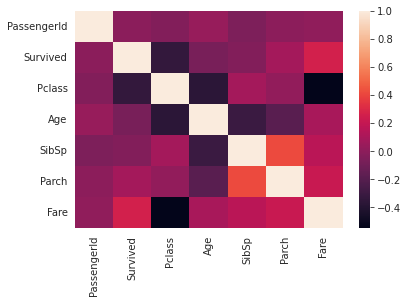

In [15]:
#Correlation
sns.heatmap(df_train[numerical_cols].corr())

In [16]:
df_train[numerical_cols].corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Observation:
* 'Pclass' and 'Fare' feature have a negative correlation. This is expected as the higher socio-economic class passengers will be having a much better luxurious experience and so their ticket cost will also be higher.


<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

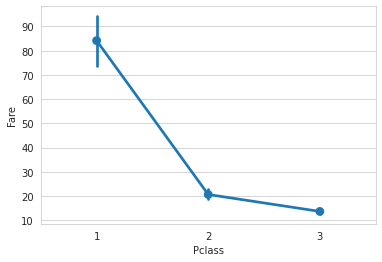

In [17]:
#Plot proving the above observation
sns.pointplot(data = df_train, x = "Pclass", y = "Fare")

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

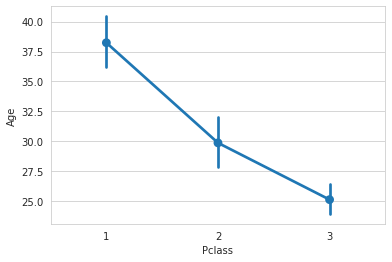

In [18]:
sns.pointplot(data = df_train, x = "Pclass", y = "Age")

Observation: The rich passengers are in the older age range

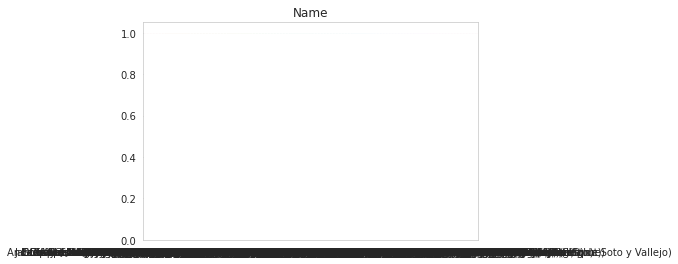

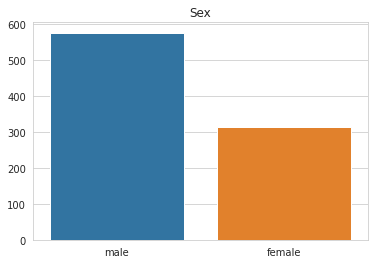

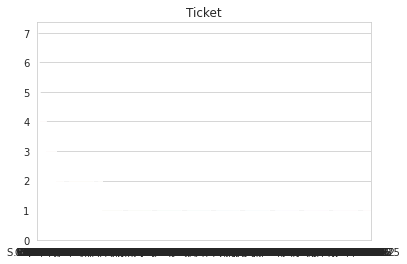

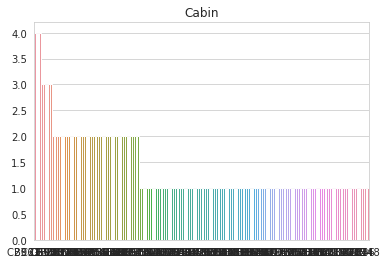

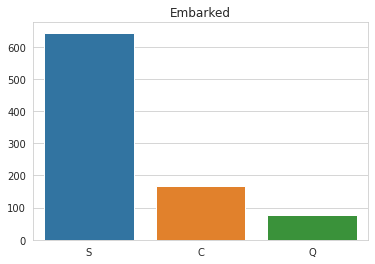

In [19]:
#Distribution of categorical data
for i in categorical_cols:
    sns.barplot(df_train[i].value_counts().index, df_train[i].value_counts().values).set_title(i)
    plt.show()

### Exploring the features

In [20]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [21]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
#PassengerId - we can drop this feature during datapreprocessing.

In [23]:
#Pclass - It is the class of the ticket purchased -> A proxy for socio-economic status
#1 = Upper, 2 = Middle, 3 = Lower

#Observation - we will have to change the type of this feature to object during data preprocesing

In [24]:
#Name -
#We can perform feature engineering on Name feature to derive important features

In [25]:
#Age-
#This feature has null values
#We will consider rounding up the values in decimal

In [26]:
#SibSp - 
#Number of siblngs or spouses
#Sibling = brother, sister, stepbrother, stepsister
#Spouse = husband, wife (mistresses and fiancés were ignored)

In [27]:
#Parch - 
#Parent = mother, father
#Child = daughter, son, stepdaughter, stepson
#Some children travelled only with a nanny, therefore parch=0 for them.

In [28]:
#Ticket - 
#Alphanumeric

#Fare -
#Passenger fare

#Cabin -
#Cabin number
#alphanumeric

#Embarked -
#S - Southampton
#C - Cherbourg
#Q - Queenstown

In [29]:
#Save passenger id from test data as it will be required while making the final submission
Test_passenger_id = df_test['PassengerId']

df_train.drop(["PassengerId"], axis=1, inplace=True)
df_test.drop(["PassengerId"], axis=1, inplace=True)

## Merge train and test data for data preprocessing

In [30]:
#combine train and test data for data preprocessing
df_merge=pd.concat([df_test.assign(ind="test"), df_train.assign(ind="train")])
df_merge.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ind,Survived
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test,NaN
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test,NaN
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test,NaN
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test,NaN
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test,NaN


In [31]:
df_train.shape, df_test.shape, df_merge.shape

((891, 11), (418, 10), (1309, 12))

## Handle missing values

In [32]:
#Missing values in merged data - ignore target feature 'Survived'
print(get_cols_with_missing_values(df_merge))

Age          263
Fare           1
Cabin       1014
Embarked       2
Survived     418
dtype: int64


In [33]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
 10  ind       1309 non-null   object 
 11  Survived  891 non-null    float64
dtypes: float64(3), int64(3), object(6)
memory usage: 132.9+ KB


In [34]:
#Handle missing categorical features

#Cabin feature has 1014/1309 vales as missing -> so we will drop this feature
df_merge.drop(["Cabin"], axis=1, inplace=True)

#Handling Missing Values in Categorical features by replacing them with the feature mode value
df_merge['Embarked'] = df_merge['Embarked'].fillna(df_merge['Embarked'].mode()[0])

In [35]:
#Handle missing numerical features
num_missing_col = ['Age', 'Fare']

#Handling Missing Values in Numerical features by replacing them with Mean value
df_merge[num_missing_col]=df_merge[num_missing_col].fillna(df_merge[num_missing_col].mean())

In [36]:
#Make sure the missing values in merged data have been handled - ignore target feature 'Survived'
print(get_cols_with_missing_values(df_merge))

Survived    418
dtype: int64


## Feature Engineering

In [37]:
#Change the type of 'Pclass' feature to 'object' as it represents socioeconomic status
df_merge['Pclass'] = df_merge['Pclass'].astype('object')

In [38]:
#Use a regular expression to get the value between the ',' and '.'
salutation_lst = []
for i in df_merge['Name']:
    match = re.search(r'.*?\s(.*?)\..*', i).group(1)
    salutation_lst.append(match)

In [39]:
#Convert the list into a dataframe
df_salutation = pd.DataFrame(salutation_lst, columns=['Salutation'])
df_salutation.index = df_merge.index
df_merge = pd.concat([df_merge, df_salutation], axis=1)

df_merge.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ind,Survived,Salutation
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,test,NaN,Mr
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,test,NaN,Mrs
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,test,NaN,Mr
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,test,NaN,Mr
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,test,NaN,Mrs


In [40]:
df_merge['Salutation'].value_counts()

Mr                   736
Miss                 256
Mrs                  191
Master                59
Dr                     8
Rev                    8
Col                    4
Ms                     2
Planke, Mr             2
Major                  2
Billiard, Master       2
y More, Miss           2
Mlle                   2
y Castellana, Mr       1
Impe, Mr               1
y Manent, Mr           1
Impe, Miss             1
Gordon, Lady           1
Messemaeker, Mrs       1
the Countess           1
Gordon, Sir            1
Capt                   1
Velde, Mr              1
Carlo, Mr              1
Shawah, Mr             1
Impe, Mrs              1
Jonkheer               1
Melkebeke, Mr          1
Mme                    1
Walle, Mr              1
Steen, Mr              1
y Castellana, Mrs      1
Carlo, Mrs             1
Khalil, Mrs            1
y Rodriguez, Mr        1
Palmquist, Mr          1
Messemaeker, Mr        1
Brito, Mr              1
y Castello, Mr         1
y Ocana, Dona          1


In [41]:
df_merge['Salutation'].value_counts().index

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Col', 'Ms', 'Planke, Mr',
       'Major', 'Billiard, Master', 'y More, Miss', 'Mlle', 'y Castellana, Mr',
       'Impe, Mr', 'y Manent, Mr', 'Impe, Miss', 'Gordon, Lady',
       'Messemaeker, Mrs', 'the Countess', 'Gordon, Sir', 'Capt', 'Velde, Mr',
       'Carlo, Mr', 'Shawah, Mr', 'Impe, Mrs', 'Jonkheer', 'Melkebeke, Mr',
       'Mme', 'Walle, Mr', 'Steen, Mr', 'y Castellana, Mrs', 'Carlo, Mrs',
       'Khalil, Mrs', 'y Rodriguez, Mr', 'Palmquist, Mr', 'Messemaeker, Mr',
       'Brito, Mr', 'y Castello, Mr', 'y Ocana, Dona', 'Planke, Mrs', 'Don',
       'Planke, Miss', 'Billiard, Mr', 'der hoef, Mr', 'Pelsmaeker, Mr',
       'Mulder, Mr', 'Cruyssen, Mr'],
      dtype='object')

In [42]:
# we will create a categorical feature named 'Class'.
# w - working class ('Dr', 'Rev', 'Col', 'Major', 'Capt')
# n - nobility 
class_col = []
nobility = ['Mr', 'Miss', 'Mrs', 'Master', 'Ms', 'Planke, Mr',
       'Billiard, Master', 'y More, Miss', 'Mlle', 'y Castellana, Mr',
       'Impe, Mr', 'y Manent, Mr', 'Impe, Miss', 'Gordon, Lady',
       'Messemaeker, Mrs', 'the Countess', 'Gordon, Sir', 'Velde, Mr',
       'Carlo, Mr', 'Shawah, Mr', 'Impe, Mrs', 'Jonkheer', 'Melkebeke, Mr',
       'Mme', 'Walle, Mr', 'Steen, Mr', 'y Castellana, Mrs', 'Carlo, Mrs',
       'Khalil, Mrs', 'y Rodriguez, Mr', 'Palmquist, Mr', 'Messemaeker, Mr',
       'Brito, Mr', 'y Castello, Mr', 'y Ocana, Dona', 'Planke, Mrs', 'Don',
       'Planke, Miss', 'Billiard, Mr', 'der hoef, Mr', 'Pelsmaeker, Mr',
       'Mulder, Mr', 'Cruyssen, Mr']

for i in df_merge['Salutation']:
    if i in nobility:
        class_col.append('n')
    else:
        class_col.append('w') 

In [43]:
#Convert the list into a dataframe
df_class = pd.DataFrame(class_col, columns=['Class'])
df_class.index = df_merge.index
df_merge = pd.concat([df_merge, df_class], axis=1)

df_merge.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ind,Survived,Salutation,Class
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,test,NaN,Mr,n
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,test,NaN,Mrs,n
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,test,NaN,Mr,n
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,test,NaN,Mr,n
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,test,NaN,Mrs,n


In [44]:
df_merge.drop(["Name"], axis=1, inplace=True)
df_merge.drop(["Salutation"], axis=1, inplace=True)

In [45]:
df_merge['Total_family'] = df_merge['SibSp'] + df_merge['Parch']

In [46]:
df_merge.drop(["SibSp"], axis=1, inplace=True)
df_merge.drop(["Parch"], axis=1, inplace=True)

In [47]:
df_merge['Age'].describe()

count    1309.000000
mean       29.881138
std        12.883193
min         0.170000
25%        22.000000
50%        29.881138
75%        35.000000
max        80.000000
Name: Age, dtype: float64

In [48]:
#We will group the 'Age' feature into groups
df_merge['Age_grp'] = pd.cut(df_merge['Age'], bins=[0,10,20,60,np.inf], labels=['Child', 'Teen', 'Adult', 'Old'])
df_merge.drop(["Age"], axis=1, inplace=True)
df_merge.head()

,Pclass,Sex,Ticket,Fare,Embarked,ind,Survived,Class,Total_family,Age_grp
0,3,male,330911,7.8292,Q,test,NaN,n,0,Adult
1,3,female,363272,7.0000,S,test,NaN,n,1,Adult
2,2,male,240276,9.6875,Q,test,NaN,n,0,Old
3,3,male,315154,8.6625,S,test,NaN,n,0,Adult
4,3,female,3101298,12.2875,S,test,NaN,n,2,Adult


In [49]:
df_merge['Fare'].describe()

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [50]:
#We will group the 'Fare' feature into groups
df_merge['Fare_grp'] = pd.cut(df_merge['Fare'], bins=[0,7,14,35,np.inf], labels=['Cheap', 'Average', 'Expensive', 'Very_Expensive'])
df_merge.drop(["Fare"], axis=1, inplace=True)
df_merge.head()

,Pclass,Sex,Ticket,Embarked,ind,Survived,Class,Total_family,Age_grp,Fare_grp
0,3,male,330911,Q,test,NaN,n,0,Adult,Average
1,3,female,363272,S,test,NaN,n,1,Adult,Cheap
2,2,male,240276,Q,test,NaN,n,0,Old,Average
3,3,male,315154,S,test,NaN,n,0,Adult,Average
4,3,female,3101298,S,test,NaN,n,2,Adult,Average


In [51]:
df_merge.drop(["Ticket"], axis=1, inplace=True)

In [52]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Pclass        1309 non-null   object  
 1   Sex           1309 non-null   object  
 2   Embarked      1309 non-null   object  
 3   ind           1309 non-null   object  
 4   Survived      891 non-null    float64 
 5   Class         1309 non-null   object  
 6   Total_family  1309 non-null   int64   
 7   Age_grp       1309 non-null   category
 8   Fare_grp      1292 non-null   category
dtypes: category(2), float64(1), int64(1), object(5)
memory usage: 84.8+ KB


In [53]:
df_merge['Age_grp'] = df_merge['Age_grp'].astype('object')
df_merge['Fare_grp'] = df_merge['Fare_grp'].astype('object')

## Encode categorical features

In [54]:
get_dummies_cols = [col for col in df_merge.columns if col not in ('ind')]

df_merge_clean_dummies = pd.get_dummies(df_merge[get_dummies_cols],drop_first=True)
df_merge.drop(get_dummies_cols,axis=1,inplace=True)
df_merge = pd.concat([df_merge,df_merge_clean_dummies],axis=1)

df_merge.head()

,ind,Survived,Total_family,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Class_w,Age_grp_Child,Age_grp_Old,Age_grp_Teen,Fare_grp_Cheap,Fare_grp_Expensive,Fare_grp_Very_Expensive
0,test,NaN,0,0,1,1,1,0,0,0,0,0,0,0,0
1,test,NaN,1,0,1,0,0,1,0,0,0,0,1,0,0
2,test,NaN,0,1,0,1,1,0,0,0,1,0,0,0,0
3,test,NaN,0,0,1,1,0,1,0,0,0,0,0,0,0
4,test,NaN,2,0,1,0,0,1,0,0,0,0,0,0,0


## Split train and test data

In [55]:
test, train= df_merge[df_merge["ind"].eq("test")], df_merge[df_merge["ind"].eq("train")]
test.drop(["Survived", "ind"], axis=1, inplace=True)
train.drop(["ind"], axis=1, inplace=True)

target = train['Survived']
train.drop(["Survived"], axis=1, inplace=True)

In [56]:
train.shape, test.shape

((891, 13), (418, 13))

## Baseline Model building

In [57]:
model_xgb = XGBClassifier(n_estimators=1000)
cv = cross_val_score(model_xgb, train, target, cv=10)
print(cv.mean())

[12:14:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [58]:
model_nb = GaussianNB()
cv = cross_val_score(model_nb, train, target, cv=10)
print(cv.mean())

0.6767415730337079


In [59]:
model_rf = RandomForestClassifier(n_estimators=1000)
cv = cross_val_score(model_rf, train, target, cv=10)
print(cv.mean())

0.8204494382022471


In [60]:
model_kn = KNeighborsClassifier(n_neighbors=5)
cv = cross_val_score(model_kn, train, target, cv=10)
print(cv.mean())

0.8069538077403247


## Voting classifier

In [61]:
voting_clf = VotingClassifier(estimators=[('xgb',model_xgb),('nb',model_nb),('rf',model_rf),('kn',model_kn)], voting='hard')
cv = cross_val_score(voting_clf, train, target, cv=10)
print(cv.mean())

[12:15:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [62]:
voting_clf.fit(train, target)

[12:15:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                   

## Get test prediction

In [63]:
test_pred = voting_clf.predict(test)

In [64]:
test_pred = test_pred.astype('int')

In [65]:
#Submission-
#Baseline submission score - 0.76794 on 22/03/2022

## Submit prediction

In [66]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': Test_passenger_id,
                       'Survived': test_pred})

output.to_csv('gender_submission.csv', index=False)